## yt: coordinate transformations via callables 


### notebook requirements

* yt installation from source on branch: https://github.com/yt-project/yt/pull/4497 

In [3]:
import yt 
import numpy as np



In [77]:
bbox = np.array([[0., 1.], [0.0, 2 * np.pi], [0, np.pi]])
sz = (50, 50, 50) 
fake_data = {"density": np.random.random(sz)}

def _neato(field, data):
    r = data["index", "r"].d
    theta = data["index", "theta"].d
    phi = data["index", "phi"].d
    phi_c = 0.25 * np.pi
    theta_c = 0.5 * np.pi

    # decay away from phi_c, theta_c
    fac = np.exp(-(((phi_c - phi) / 0.5) ** 2)) * np.exp(
        -(((theta_c - theta) / 0.5) ** 2)
    ) 
    
    # cos^2 variation in r with slight increase towards rmin
    rfac = np.cos((r - 0.1) / 0.9 * 3 * np.pi) ** 2 * (1 - 0.25 * (r - 0.1) / 0.9)
    field = fac * rfac + 0.1 * np.random.random(r.shape)

    # field = field * (theta <= 2.0) * (phi < 1.25)
    return field


yt.add_field(
    name=("stream", "neat"),
    function=_neato,
    sampling_type="local",
    units="",
    force_override=True,
    take_log=False,
)

ds = yt.load_uniform_grid(
    fake_data,
    sz,
    bbox=bbox,
    nprocs=256,
    geometry="spherical", 
    axis_order =("r", "phi", "theta"),
    length_unit="m",
)


yt : [INFO     ] 2023-06-13 14:18:11,987 Parameters: current_time              = 0.0
yt : [INFO     ] 2023-06-13 14:18:11,988 Parameters: domain_dimensions         = [50 50 50]
yt : [INFO     ] 2023-06-13 14:18:11,990 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2023-06-13 14:18:11,991 Parameters: domain_right_edge         = [1.         6.28318531 3.14159265]
yt : [INFO     ] 2023-06-13 14:18:11,993 Parameters: cosmological_simulation   = 0


yt : [INFO     ] 2023-06-13 14:18:19,034 xlim = -1.000000 1.000000
yt : [INFO     ] 2023-06-13 14:18:19,035 ylim = -1.000000 1.000000
yt : [INFO     ] 2023-06-13 14:18:19,036 Setting origin='native' for spherical geometry.
yt : [INFO     ] 2023-06-13 14:18:19,042 xlim = -1.000000 1.000000
yt : [INFO     ] 2023-06-13 14:18:19,043 ylim = -1.000000 1.000000
yt : [INFO     ] 2023-06-13 14:18:19,048 Making a fixed resolution buffer of (('stream', 'neat')) 800 by 800



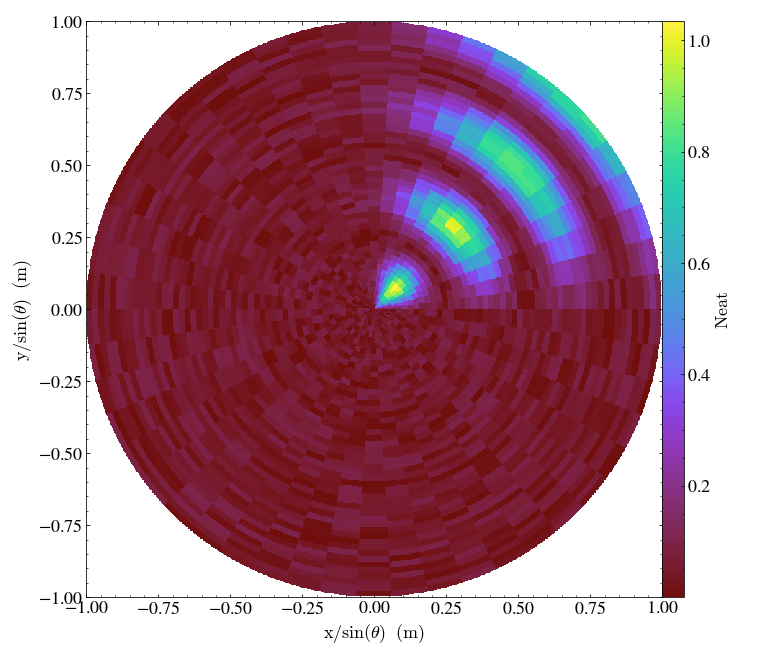

In [78]:
yt.SlicePlot(ds, "theta", ("stream", "neat"))

## Manual interpolation to numpy arrays

In [26]:
ad = ds.all_data()
x = ad[('index', 'cartesian_x')]
y = ad[('index', 'cartesian_y')]
z = ad[('index', 'cartesian_z')]
r = ad[('index', 'r')]
neat = ad[('stream', 'neat')]
theta = ad[('index', 'theta')]
phi = ad[('index', 'phi')]

In [40]:
from scipy.interpolate import griddata
import numpy as np 

# the grid to interpolate onto
x_i1d = np.linspace(-1, 1, 150)
y_i1d = np.linspace(-1, 1, 150)
z_i1d = np.linspace(-1, 1, 150)
x_i, y_i, z_i = np.meshgrid(x_i1d, y_i1d, z_i1d, indexing='ij')
real_grid_r = np.sqrt(x_i**2+ y_i**2 + z_i**2) # useful for later

def move_to_grid(griv_var):
    gridded_val = griddata((x.ravel(), y.ravel(), z.ravel()), griv_var.ravel(), (x_i, y_i, z_i), method='nearest')
    # nearest method will not apply any distance cutoff, so lets do that ourselves
    gridded_val[real_grid_r>1] = np.nan
    return gridded_val

In [45]:
%%time 
gridded_neat = move_to_grid(neat)

CPU times: user 5.31 s, sys: 35.8 ms, total: 5.34 s
Wall time: 5.34 s


Text(0.5, 1.0, 'r(x = 0ish)')

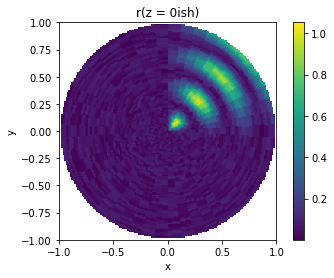

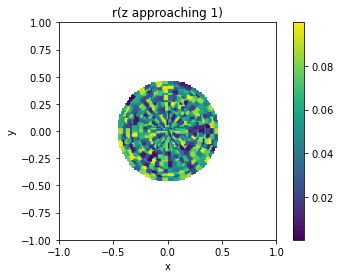

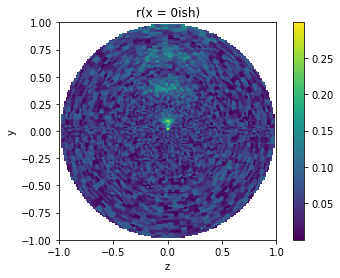

In [46]:
import matplotlib.pyplot as plt 

plt.figure()
plt.imshow(gridded_neat[:,:,75], extent=((-1, 1, -1, 1)), origin='lower')
plt.colorbar()
plt.xlabel('x')
plt.ylabel('y')
plt.title('r(z = 0ish)')

plt.figure()
plt.imshow(gridded_neat[:,:,140], extent=((-1, 1, -1, 1)), origin='lower')
plt.colorbar()
plt.xlabel('x')
plt.ylabel('y')
plt.title('r(z approaching 1)')

plt.figure()
plt.imshow(gridded_neat[75,:,:], extent=((-1, 1, -1, 1)), origin='lower')
plt.colorbar()
plt.xlabel('z')
plt.ylabel('y')
plt.title('r(x = 0ish)')

## loading back into yt 

yt : [INFO     ] 2023-06-13 13:46:44,798 Parameters: current_time              = 0.0
yt : [INFO     ] 2023-06-13 13:46:44,800 Parameters: domain_dimensions         = [150 150 150]
yt : [INFO     ] 2023-06-13 13:46:44,801 Parameters: domain_left_edge          = [-1. -1. -1.]
yt : [INFO     ] 2023-06-13 13:46:44,803 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2023-06-13 13:46:44,805 Parameters: cosmological_simulation   = 0
yt : [INFO     ] 2023-06-13 13:46:44,952 xlim = -1.000000 1.000000
yt : [INFO     ] 2023-06-13 13:46:44,953 ylim = -1.000000 1.000000
yt : [INFO     ] 2023-06-13 13:46:44,958 xlim = -1.000000 1.000000
yt : [INFO     ] 2023-06-13 13:46:44,960 ylim = -1.000000 1.000000
yt : [INFO     ] 2023-06-13 13:46:44,967 Making a fixed resolution buffer of (('stream', 'gridded_neat')) 800 by 800



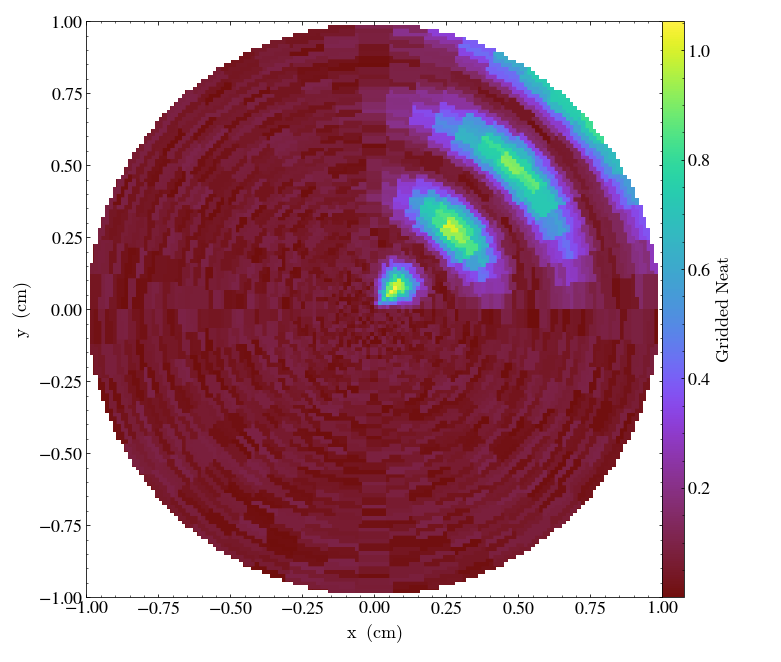

In [43]:

data = {'gridded_neat': gridded_neat}


def _neato(field, data):
    gn = data[("stream", "gridded_neat")]
    gn[np.isnan(gn)] = 0.0
    return gn 


yt.add_field(
    name=("stream", "neat"),
    function=_neato,
    sampling_type="local",
    units="",
    force_override=True,
    take_log=False,
)

ds_2 = yt.load_uniform_grid(data, 
                            gridded_neat.shape, 
                            bbox = np.array([[-1, 1], [-1, 1], [-1, 1]]))
slc = yt.SlicePlot(ds_2, "z", ("stream", "gridded_neat"))
slc.set_log(("stream", "gridded_neat"), False)

and now, we can utilize yt methods that are implemented for cartesian but not spherical geometries:

yt : [INFO     ] 2023-06-13 13:46:53,010 Projection completed
yt : [INFO     ] 2023-06-13 13:46:53,011 xlim = -1.000000 1.000000
yt : [INFO     ] 2023-06-13 13:46:53,012 ylim = -1.000000 1.000000
yt : [INFO     ] 2023-06-13 13:46:53,018 xlim = -1.000000 1.000000
yt : [INFO     ] 2023-06-13 13:46:53,019 ylim = -1.000000 1.000000
yt : [INFO     ] 2023-06-13 13:46:53,022 Making a fixed resolution buffer of (('stream', 'neat')) 800 by 800



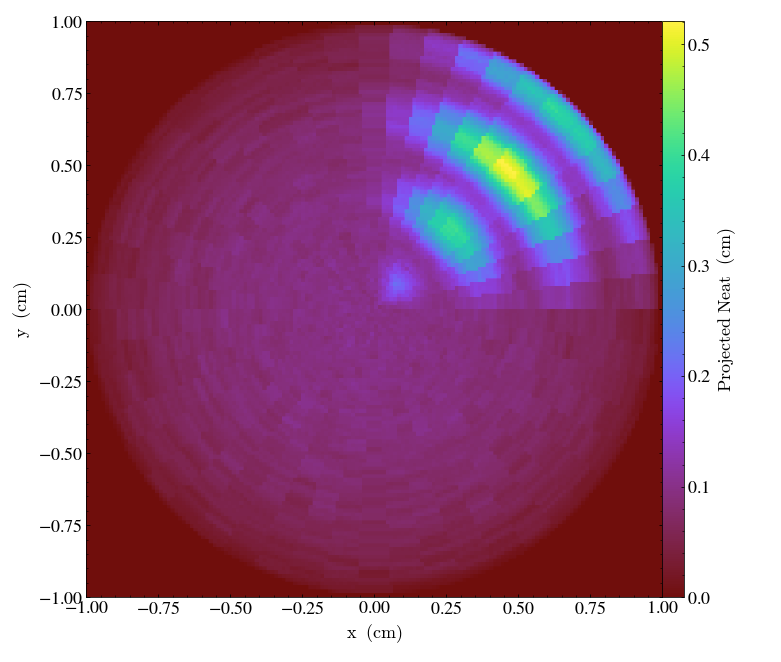

In [44]:
yt.ProjectionPlot(ds_2, "z", ("stream", "neat"))